[View in Colaboratory](https://colab.research.google.com/github/vivekster12/Parser/blob/master/param_tuning_NER.ipynb)

In [0]:
from __future__ import unicode_literals, print_function
import random
import spacy
import ast
from pathlib import Path

In [0]:
!pip install spacy

In [0]:
import pandas as pd
import numpy as np
from google.colab import files
import io
import ast

In [4]:
uploaded = files.upload()

Saving Opioid_FREETEXT_HANDCODING.csv to Opioid_FREETEXT_HANDCODING.csv


In [0]:
corpus = pd.read_csv(io.StringIO(uploaded['Opioid_FREETEXT_HANDCODING.csv'].decode('CP1252')),sep=',')

In [0]:
prescriptions = corpus['freetext_posology'].values

In [7]:
up = files.upload()

Saving new_NER_reg.csv to new_NER_reg.csv


In [0]:
NER_reg = pd.read_csv(io.StringIO(up['new_NER_reg.csv'].decode('utf-8')),sep=',', header = None)

In [0]:
TRAIN_CORPUS = []
for sample in NER_reg.values:
#   print (type(sample[1]))
  print ((sample)[1])
  sample[1] = (ast.literal_eval(sample[1]))
  
  TRAIN_CORPUS.append(tuple(sample))

In [0]:
for text, annotations in TRAIN_CORPUS:
  for ent in annotations.get('entities'):
    if ('' in ent):
      print (text)
      print (ent)
#       annotations.get('entities').remove(ent)

In [0]:
print (len(TRAIN_CORPUS))
for line in TRAIN_CORPUS:
  print (line)

In [0]:
# entity labels 
L_FREQ = 'FREQ'
L_VAR_FREQ = 'VAR_FREQ'
L_DOSE = 'DOSE'
L_VAR_DOSE = 'VAR_DOSE'
L_PRN = 'PRN'
L_VAR_OVER_TIME = 'VAR_OVER_TIME'
L_STRENGTH = 'STRENGTH'
L_UNITS = 'UNITS'
L_NUM_TABS = 'NUM_TABS'
L_VAR_NUM_TABS = 'VAR_NUM_TABS'
L_TABS = 'TABS'

In [0]:
def spacy_ner(TRAIN_DATA, VALIDATION_DATA, n_iter, model=None, new_model_name='TRIAL',output_dir=None):
    """Load the model, set up the pipeline and train the entity recognizer."""
    if model is not None:
        nlp = spacy.load(model)  # load existing spaCy model
        print("Loaded model '%s'" % model)
    else:
        nlp = spacy.blank('en')  # create blank Language class
        print("Created blank 'en' model")

    # create the built-in pipeline components and add them to the pipeline
    # nlp.create_pipe works for built-ins that are registered with spaCy
    if 'ner' not in nlp.pipe_names:
        ner = nlp.create_pipe('ner')
        nlp.add_pipe(ner, last=True)
    # otherwise, get it so we can add labels
    else:
        ner = nlp.get_pipe('ner')

    # add labels
    for _,annotations in TRAIN_DATA:
#       print (type(annotations))
      for ent in annotations.get('entities'):
        ner.add_label(ent[2])
   

    # add new entity label to entity recognizer
    ner.add_label(L_DOSE)
    ner.add_label(L_VAR_DOSE)
    ner.add_label(L_FREQ)
    ner.add_label(L_VAR_FREQ)
    ner.add_label(L_PRN)
    ner.add_label(L_VAR_OVER_TIME)
    ner.add_label(L_STRENGTH)
    ner.add_label(L_UNITS)
    ner.add_label(L_NUM_TABS)
    ner.add_label(L_VAR_NUM_TABS)
    ner.add_label(L_TABS)
    
    if model is None:
        optimizer = nlp.begin_training()
    else:
        # Note that 'begin_training' initializes the models, so it'll zero out
        # existing entity types.
        optimizer = nlp.entity.create_optimizer()
    
    
    # get names of other pipes to disable them during training
    other_pipes = [pipe for pipe in nlp.pipe_names if pipe != 'ner']
    with nlp.disable_pipes(*other_pipes):  # only train NER
        d_val_acc = []
        vd_val_acc = []
        f_val_acc = []
        vf_val_acc = []
        
        d_tr_acc = []
        vd_tr_acc = []
        f_tr_acc = []
        vf_tr_acc = []
        
        pm_tr_acc = []
        pm_val_acc = []
        
        for itn in range(n_iter):
            print ('iter: ',itn)
            random.shuffle(TRAIN_DATA)
            losses = {}
            # learn over all training samples
            for text, annotations in TRAIN_DATA:
              nlp.update([text], [annotations], sgd=optimizer, drop=0.35, losses=losses)
              
            print(losses)
            
            # for each iteration, need training loss and validation loss
            training_pred = []
            for text, annotations in TRAIN_DATA:
              doc = nlp(text)
              training_pred.append([(ent.text, ent.label_) for ent in doc.ents])
            
            # need to get valdiation loss here
            output_dir = Path('Libraries\Documents')
            if not output_dir.exists():
              output_dir.mkdir()
            nlp.to_disk(output_dir)
            nlp2 = spacy.load(output_dir)
            validation_pred = []
            for text, annotations in VALIDATION_DATA:
              doc = nlp2(text)
              validation_pred.append([(ent.text, ent.label_) for ent in doc.ents])
            
            # calc training loss and validation loss
            training_org_res = organize_output(training_pred, TRAIN_DATA)
            validation_org_res = organize_output(validation_pred, VALIDATION_DATA)

            train_score = gen_score(training_org_res)
            validation_score = gen_score(validation_org_res)
            
            d_val_acc.append(get_acc(validation_score)[0])
            vd_val_acc.append(get_acc(validation_score)[1])
            f_val_acc.append(get_acc(validation_score)[3])
            vf_val_acc.append(get_acc(validation_score)[4])
            
            d_tr_acc.append(get_acc(train_score)[0])
            vd_tr_acc.append(get_acc(train_score)[1])
            f_tr_acc.append(get_acc(train_score)[3])
            vf_tr_acc.append(get_acc(train_score)[4])
            
            pm_tr_acc.append(get_acc(train_score)[12])
            pm_val_acc.append(get_acc(validation_score)[12])
            
            
    return d_val_acc,vd_val_acc,f_val_acc,vf_val_acc,d_tr_acc,vd_tr_acc,f_tr_acc,vf_tr_acc, pm_tr_acc, pm_val_acc


In [0]:
from sklearn.model_selection import KFold

In [0]:
# scrap (K_FOLD)
def do_scrap(k,num_it):
  kf = KFold(n_splits=k, shuffle=True)
  kf.get_n_splits(TRAIN_CORPUS)
  print(kf)
  
  pm_tr_k = []
  pm_val_k = []
  
  d_tr_k = []
  d_val_k = []
  
  vd_tr_k = []
  vd_val_k = []
  
  f_tr_k = []
  f_val_k = []
  
  vf_tr_k = []
  vf_val_k = []
  
  
  for i,j in kf.split(TRAIN_CORPUS, y=None):
  # i is train indices
  # j is test indices
    TRAIN_DATA = []
    VALIDATION_DATA = []
    for index in i:
      TRAIN_DATA.append(TRAIN_CORPUS[index])
    for index in j:
      VALIDATION_DATA.append(TRAIN_CORPUS[index])
    
    d_val_acc,vd_val_acc,f_val_acc,vf_val_acc,d_tr_acc,vd_tr_acc,f_tr_acc,vf_tr_acc, pm_tr_acc, pm_val_acc = spacy_ner(TRAIN_DATA,VALIDATION_DATA,num_it)
    
    pm_tr_k.append(pm_tr_acc)
    pm_val_k.append(pm_val_acc)
    
    d_tr_k.append(d_tr_acc)
    d_val_k.append(d_val_acc)
    
    vd_tr_k.append(vd_tr_acc)
    vd_val_k.append(vd_val_acc)
    
    f_tr_k.append(f_tr_acc)
    f_val_k.append(f_val_acc)
    
    vf_tr_k.append(vf_tr_acc)
    vf_val_k.append(vf_val_acc)
    
  
  return d_tr_k, d_val_k, vd_tr_k, vd_val_k, f_tr_k, f_val_k, vf_tr_k, vf_val_k, pm_tr_k, pm_val_k

In [0]:
d_tr_k, d_val_k, vd_tr_k, vd_val_k, f_tr_k, f_val_k, vf_tr_k, vf_val_k, pm_tr_k, pm_val_k = do_scrap(4,100)

In [0]:
def get_avg(arr):
  a = np.array(arr)
  return [np.mean(col) for col in a.T]

In [0]:
dose_train = get_avg(d_tr_k)
dose_val = get_avg(d_val_k)

var_dose_train = get_avg(vd_tr_k)
var_dose_val = get_avg(vd_val_k)

freq_train = get_avg(f_tr_k)
freq_val = get_avg(f_val_k)

var_freq_train = get_avg(vf_tr_k)
var_freq_val = get_avg(vf_val_k)

pm_train = get_avg(pm_tr_k)
pm_val = get_avg(pm_val_k)

In [0]:
def do_k_fold_cross(k,num_it):
  kf = KFold(n_splits=k, shuffle=True)
  kf.get_n_splits(TRAIN_CORPUS)
  print(kf)
  pm_tr_k = []
  pm_val_k = []
  
  for i,j in kf.split(TRAIN_CORPUS, y=None):
  # i is train indices
  # j is test indices
    TRAIN_DATA = []
    VALIDATION_DATA = []
    for index in i:
      TRAIN_DATA.append(TRAIN_CORPUS[index])
    for index in j:
      VALIDATION_DATA.append(TRAIN_CORPUS[index])
    
    d_val_acc,vd_val_acc,f_val_acc,vf_val_acc,d_tr_acc,vd_tr_acc,f_tr_acc,vf_tr_acc, pm_tr_acc, pm_val_acc = spacy_ner(TRAIN_DATA,VALIDATION_DATA,num_it)
    pm_tr_k.append(pm_tr_acc)
    pm_val_k.append(pm_val_acc)
#     break
  return d_val_acc,vd_val_acc,f_val_acc,vf_val_acc,d_tr_acc,vd_tr_acc,f_tr_acc,vf_tr_acc, pm_tr_acc, pm_val_acc
  

In [0]:
num_it = 100

In [0]:
d_val_acc,vd_val_acc,f_val_acc,vf_val_acc,d_tr_acc,vd_tr_acc,f_tr_acc,vf_tr_acc, pm_tr_acc, pm_val_acc = do_k_fold_cross(10,num_it)


In [0]:
x = np.linspace(0,num_it,num_it)

In [41]:
to_csv(d_tr_k, d_val_k, vd_tr_k, vd_val_k, f_tr_k, f_val_k, vf_tr_k, vf_val_k, pm_tr_k, pm_val_k)

Uploaded file with ID 1IgbzdZCjb1EY1HF8jlWJBerWt8XkaW5G
Uploaded file with ID 1TdthScSGEyjhU1_0zixbkCwO3YlwF2Mi
Uploaded file with ID 1M8_XTSlGCt14l5RQ94A8E_zWwbRT821S
Uploaded file with ID 1Pc9RXWRGKlUqXe_K5WqmtNIbdh571hpa
Uploaded file with ID 1fMQmHsmnkPt3phGTWzLUQ1pjv1Zcylxc
Uploaded file with ID 1TcSKOsOnNTBiuw0IpVrk_sM5vHWEnQ-w
Uploaded file with ID 1eRRu6tmANEtc_-rYOrr27E_lNnHhARbz
Uploaded file with ID 1T96eSafuFaM5lxJ5do8Gu9oywSG6LAk5
Uploaded file with ID 1xI-zFjpgZCleSzw9-uPwuhVWSXERHMFb
Uploaded file with ID 1xsCabeNVBQ2qIfZGYYUOyjr7bOsLuvII


In [0]:
def to_csv(d_tr_k, d_val_k, vd_tr_k, vd_val_k, f_tr_k, f_val_k, vf_tr_k, vf_val_k, pm_tr_k, pm_val_k):
  
  df = pd.DataFrame(data = d_tr_k)
  df.to_csv('d_tr_k.csv', index = False)
  # Create & upload a file.
  uploaded = drive.CreateFile({'title': 'd_tr_k.csv'})
  uploaded.SetContentFile('d_tr_k.csv')
  uploaded.Upload()
  print('Uploaded file with ID {}'.format(uploaded.get('id')))
  
  df = pd.DataFrame(data = d_val_k)
  df.to_csv('d_val_k.csv', index = False)
  # Create & upload a file.
  uploaded = drive.CreateFile({'title': 'd_val_k.csv'})
  uploaded.SetContentFile('d_val_k.csv')
  uploaded.Upload()
  print('Uploaded file with ID {}'.format(uploaded.get('id')))
  
  df = pd.DataFrame(data = vd_tr_k)
  df.to_csv('vd_tr_k.csv', index = False)
  # Create & upload a file.
  uploaded = drive.CreateFile({'title': 'vd_tr_k.csv'})
  uploaded.SetContentFile('vd_tr_k.csv')
  uploaded.Upload()
  print('Uploaded file with ID {}'.format(uploaded.get('id')))
  
  df = pd.DataFrame(data = vd_val_k)
  df.to_csv('vd_val_k.csv', index = False)
  # Create & upload a file.
  uploaded = drive.CreateFile({'title': 'vd_val_k.csv'})
  uploaded.SetContentFile('vd_val_k.csv')
  uploaded.Upload()
  print('Uploaded file with ID {}'.format(uploaded.get('id')))
  
  df = pd.DataFrame(data = f_tr_k)
  df.to_csv('f_tr_k.csv', index = False)
  # Create & upload a file.
  uploaded = drive.CreateFile({'title': 'f_tr_k.csv'})
  uploaded.SetContentFile('f_tr_k.csv')
  uploaded.Upload()
  print('Uploaded file with ID {}'.format(uploaded.get('id')))
  
  df = pd.DataFrame(data = f_val_k)
  df.to_csv('f_val_k.csv', index = False)
  # Create & upload a file.
  uploaded = drive.CreateFile({'title': 'f_val_k.csv'})
  uploaded.SetContentFile('f_val_k.csv')
  uploaded.Upload()
  print('Uploaded file with ID {}'.format(uploaded.get('id')))
  
  df = pd.DataFrame(data = vf_tr_k)
  df.to_csv('vf_tr_k.csv', index = False)
  # Create & upload a file.
  uploaded = drive.CreateFile({'title': 'vf_tr_k.csv'})
  uploaded.SetContentFile('vf_tr_k.csv')
  uploaded.Upload()
  print('Uploaded file with ID {}'.format(uploaded.get('id')))
  
  df = pd.DataFrame(data = vf_val_k)
  df.to_csv('vf_val_k.csv', index = False)
  # Create & upload a file.
  uploaded = drive.CreateFile({'title': 'vf_val_k.csv'})
  uploaded.SetContentFile('vf_val_k.csv')
  uploaded.Upload()
  print('Uploaded file with ID {}'.format(uploaded.get('id')))
  
  df = pd.DataFrame(data = pm_tr_k)
  df.to_csv('pm_tr_k.csv', index = False)
  # Create & upload a file.
  uploaded = drive.CreateFile({'title': 'pm_tr_k.csv'})
  uploaded.SetContentFile('pm_tr_k.csv')
  uploaded.Upload()
  print('Uploaded file with ID {}'.format(uploaded.get('id')))
  
  df = pd.DataFrame(data = pm_val_k)
  df.to_csv('pm_val_k.csv', index = False)
  # Create & upload a file.
  uploaded = drive.CreateFile({'title': 'pm_val_k.csv'})
  uploaded.SetContentFile('pm_val_k.csv')
  uploaded.Upload()
  print('Uploaded file with ID {}'.format(uploaded.get('id')))
  
  
  
  

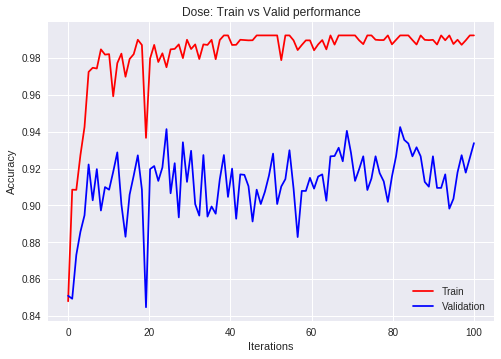

In [39]:
plt.plot(x, dose_train, color='r', ls = '-', label='Train')
plt.plot(x, dose_val, color='b', ls = '-', label='Validation')
plt.title('Dose: Train vs Valid performance')
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.legend()

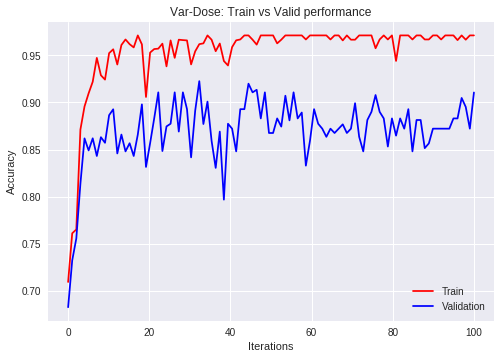

In [35]:
plt.plot(x, var_dose_train, color='r', ls = '-', label = 'Train')
plt.plot(x, var_dose_val, color='b', ls = '-', label = 'Validation')
plt.title('Var-Dose: Train vs Valid performance')
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.legend()

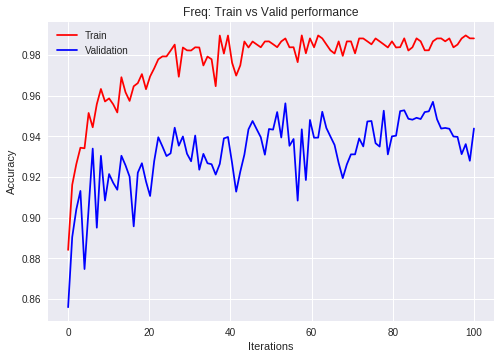

In [36]:
plt.plot(x, freq_train, color='r', ls = '-', label = 'Train')
plt.plot(x, freq_val, color='b', ls = '-', label = 'Validation')
plt.title('Freq: Train vs Valid performance')
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.legend()

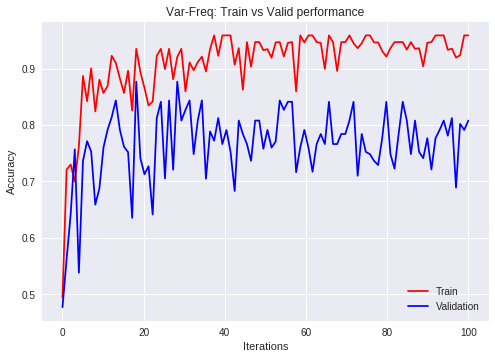

In [37]:
plt.plot(x, var_freq_train, color='r', ls = '-', label = 'Train')
plt.plot(x, var_freq_val, color='b', ls = '-', label = 'Validation')
plt.title('Var-Freq: Train vs Valid performance')
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.legend()

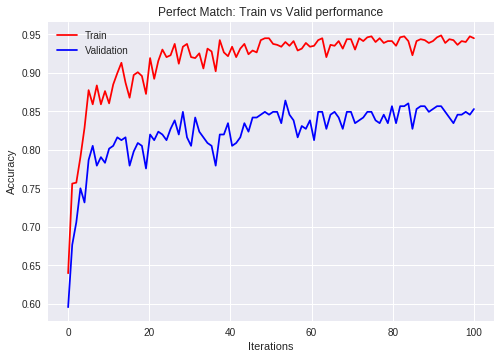

In [38]:
plt.plot(x, pm_train, color='r', ls = '-', label = 'Train')
plt.plot(x, pm_val, color='b', ls = '-', label = 'Validation')
plt.title('Perfect Match: Train vs Valid performance')
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.legend()

In [0]:
def organize_output(parse_output, DATA):
  org_res = []
  entities = ['DOSE', 'VAR_DOSE', 'QUANTITY', 'FREQ', 'VAR_FREQ', 'PRN', 'VAR_OVER_TIME', 'STRENGTH', 'UNITS', 'NUM_TABS', 'VAR_NUM_TABS', 'TABS']
  
  for i,line in enumerate(parse_output): 
    table = dict((el,[]) for el in entities)
  
  #   format of dict: 'key': ['pred', 'actual']
#     pred_arr.append(line[1])
#     print (line[0])
    for p_ent in line:
      if (p_ent[1] in table):
        table[p_ent[1]].append(p_ent[0])
      else:
        print ('this should not happen')
    
#     print (VALIDATION_DATA[i][0])
    
    for a_ent in DATA[i][1].get('entities'):
      if (a_ent[2] in table):
        table[a_ent[2]].append(DATA[i][0][a_ent[0]:a_ent[1]])
      else:
        print ('this should not happen')

#     print ('here')
    org_res.append(table)
  return org_res

In [0]:
# scoring convention: None --> no actual value, no pred value, 1 --> pred value = actual value, 
# 0 --> pred value != actual value (either it predicted wrong value or did not predict anything when it should have)
def gen_score(results):
  entities = ['DOSE', 'VAR_DOSE', 'QUANTITY', 'FREQ', 'VAR_FREQ', 'PRN', 'VAR_OVER_TIME', 'STRENGTH', 'UNITS', 'NUM_TABS', 'VAR_NUM_TABS', 'TABS']
  score_arr = []
  for i,line in enumerate(results):
    score = [np.nan] * len(entities)
    
    
    for key, value in line.items():
      if (len(value) == 0):
        continue

      elif (len(value)%2 == 0):
#         print ('enter')
        p1 = 0
        p2 = int(len(value)/2)
        wrong = 0
        while (True):
#           print (len(value))
#           print (p1)
#           print (p2)
          # check if values (pred and act) are equal
          if (p2 >= len(value) and wrong == 0):
            score[entities.index(key)] = 1
            break
          elif (value[p1] != value[p2]):
            score[entities.index(key)] = 0
            wrong = 1
            break
          else:
            p1 +=1
            p2 +=1
        
#         print ('exit')

      else:
        score[entities.index(key)]= 0

    score_arr.append(score)
#     print (score)
  
  return score_arr

In [0]:
def get_acc(score_table):
  for line in score_table:
    if (0 not in line):
      line.append(1)
    else:
      line.append(np.nan)

  #   conv to np array
  matrix = np.array(score_table)

  temp = []
  for i,ent in enumerate(matrix.T):
    if (i != 12):
      acc = np.count_nonzero(ent == 1)/sum(~np.isnan(ent))
    else:
      acc = np.count_nonzero(ent == 1)/len(ent)
    temp.append(acc)
  
  return temp

In [0]:
import matplotlib.pyplot as plt

In [0]:
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once in a notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once in a notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)